# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2022/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November 1st, 2022 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/ (we won't be doing peergrading, but we'll still use http://peergrade.io/ for the handin.)

# Data

This assignment will be based on the DC and Marvel superhero dataset you downloaded during the Week 4 exercises. It's important that you work with your own dataset.

You will need the network structure and the page texts to complete the assignment.

To show that you have collected these files, please place your files somewhere that's accessible online (e.g. a github repo or a webpage) and link to your files from your notebook. (We will appreciate it if you store the wiki pages in plain text and the network as an edgelist. )

In [2]:
import networkx as nx
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy import stats
from fa2 import ForceAtlas2
import powerlaw

with open('graph.pickle', 'rb') as handle:
    G = pickle.load(handle)

# Basic Stats

Write a short paragraph describing the network. The paragraph should contain the following information

* The number of nodes and links. 

The network is constructed using Wikipedia pages of characters from the Marvel and DC universe, where each node represents the character.  The network is a directed graph: if the Wikipedia page of character A links to the Wikipedia page of character B, an outgoing edge is established from node A to B. 

Each node has two attributes: "universe" and "content length". The "universe" attribute describes which universe the character is from, either Marvel or DC. The "content length" attribute describes how many words there are in each character's Wikipedia page. In total, there are 2091 nodes and 26739 links, as seen below.


In [23]:
nodes = len(G.nodes())
edges = len(G.edges())
print("The network has {} nodes and {} links.".format(nodes, edges))

The network has 2091 nodes and 26739 links.


* The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.


Below, we have some summary statistics for the in-degree and out-degree of the network

In [24]:
in_degs = [G.in_degree(node) for node in G.nodes()]
out_degs = [G.out_degree(node) for node in G.nodes()]

# In-degree
print("The average of the in-degrees is:", np.mean(in_degs))
print("The median of the in-degrees is:", np.median(in_degs))
print("The mode of the in-degrees is:", stats.mode(in_degs).mode[0]) # rimelig sikker på det her er rigtigt
print("The minimum of the in-degree is:", np.min(in_degs))
print("The maximum of the in-degree is:", np.max(in_degs))
print("\n")

# Out-degree
print("The average of the out-degrees is:", np.mean(out_degs))
print("The median of the out-degrees is:", np.median(out_degs))
print("The mode of the out-degrees is:", stats.mode(out_degs).mode[0])
print("The minimum of the out-degree is:", np.min(out_degs))
print("The maximum of the out-degree is:", np.max(out_degs))



The average of the in-degrees is: 12.787661406025824
The median of the in-degrees is: 5.0
The mode of the in-degrees is: 1
The minimum of the in-degree is: 0
The maximum of the in-degree is: 434


The average of the out-degrees is: 12.787661406025824
The median of the out-degrees is: 9.0
The mode of the out-degrees is: 0
The minimum of the out-degree is: 0
The maximum of the out-degree is: 109



We also want the degree distributions and a plot of the network

(Friendly hint: Remember figure captions.)

* Create in- and out-going degree distributions as described in Lecture 5.

In [25]:
in_degs = [i[1] for i in G.in_degree()]

min_ = min(in_degs)
max_ = max(in_degs)

height, bins = np.histogram(in_degs, bins=20)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)

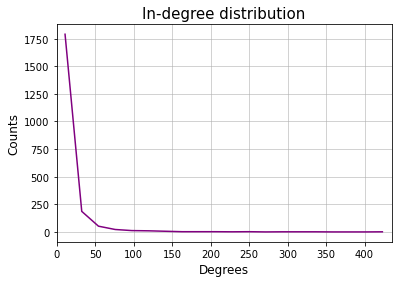

In [26]:
plt.title('In-degree distribution', size=15)
plt.xlabel('Degrees', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='purple')
plt.grid(alpha=0.7)
plt.rc('axes', axisbelow=True)
plt.xscale("linear")
plt.yscale("linear")
plt.xlim(0, max_+1);

In [27]:
out_degs = [i[1] for i in G.out_degree()]

min_ = min(out_degs)
max_ = max(out_degs)
        
height, bins = np.histogram(out_degs, bins=np.arange(min_,max_+2) - 1/2)

binmids = []
for i in range(len(bins)-1):
    binmids.append((bins[i]+bins[i+1])/2)

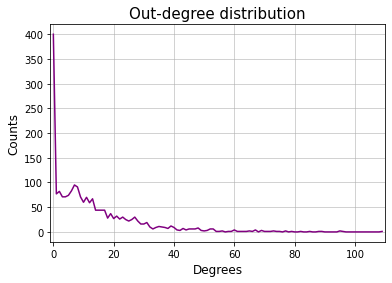

In [28]:
plt.title('Out-degree distribution', size=15)
plt.xlabel('Degrees', size=12)
plt.ylabel('Counts', size=12)
plt.plot(binmids, height, color='purple')
plt.grid(alpha=0.7)
plt.rc('axes', axisbelow=True)
plt.xscale("linear")
plt.yscale("linear")
plt.xlim(-1, max_+1);

* Estimate the slope of the incoming degree distribtion as described in Lecture 5.

We use the ``powerlaw`` library to estimate the slope.

In [38]:
print(powerlaw.Fit([G.in_degree(node) for node in G.nodes()]).alpha)

Calculating best minimal value for power law fit
2.5329034312435397


Values less than or equal to 0 in data. Throwing out 0 or negative values


The authors of the paper found that the slope of the out-degrees are slightly higher than the slope of the in-degrees. And according to them, the out-degree distribution is often not a clear power law. This is also what we see in the degree distribution plots above.

* Plot the network using the Force Atlas algorithm as described in Lecture 5.

We will now plot the network using the Force Atlas algorithm. First, we find the greatest connected component. 

In [3]:
# make G undirected
G_undirected = G.to_undirected()

# get node attribute "universe" of the undirected graph
node_attr = nx.get_node_attributes(G_undirected, "universe")

largest_cc = G.subgraph(max(nx.connected_components(G_undirected), key=len)).copy()
print("Number of nodes in the largest connected component:", len(largest_cc.nodes()))

Number of nodes in the largest connected component: 2087


Thereafter, we compute the parameters necessary for plotting the network with the Force Atlas algorithm. The node size of each node depends on the degree of the node. The colour of each node depends on whether it belongs to the Marvel or DC universe. Finally, there are three different edge colours: one for links between two Marvel characters, one for links between two DC characters and one for linking two nodes from different universes.

In [53]:
# compute node size 
node_size = [G_undirected.degree()[i] for i in G_undirected.nodes()]

# create colormap of each node
color_map = ["#C41E3A" if node_attr[n] == 'marvel' else "#000000" for n in G_undirected.nodes()]

# create colormap for edges
color_a = '#00FFFF' # cyan
color_b = '#FFC300' # yellow
color_c = '#BF40BF' # magenta

edge_color = []

for edge in G_undirected.edges():
    from_, to_ = edge
    if node_attr[from_] == 'marvel' and node_attr[to_] == 'marvel':
        edge_color.append(color_a)
    elif node_attr[from_] == 'dc' and node_attr[to_] == 'dc':
        edge_color.append(color_b)
    else:
        edge_color.append(color_c)
        

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:56<00:00, 17.15it/s]


BarnesHut Approximation  took  15.47  seconds
Repulsion forces  took  97.22  seconds
Gravitational forces  took  0.38  seconds
Attraction forces  took  0.66  seconds
AdjustSpeedAndApplyForces step  took  1.39  seconds


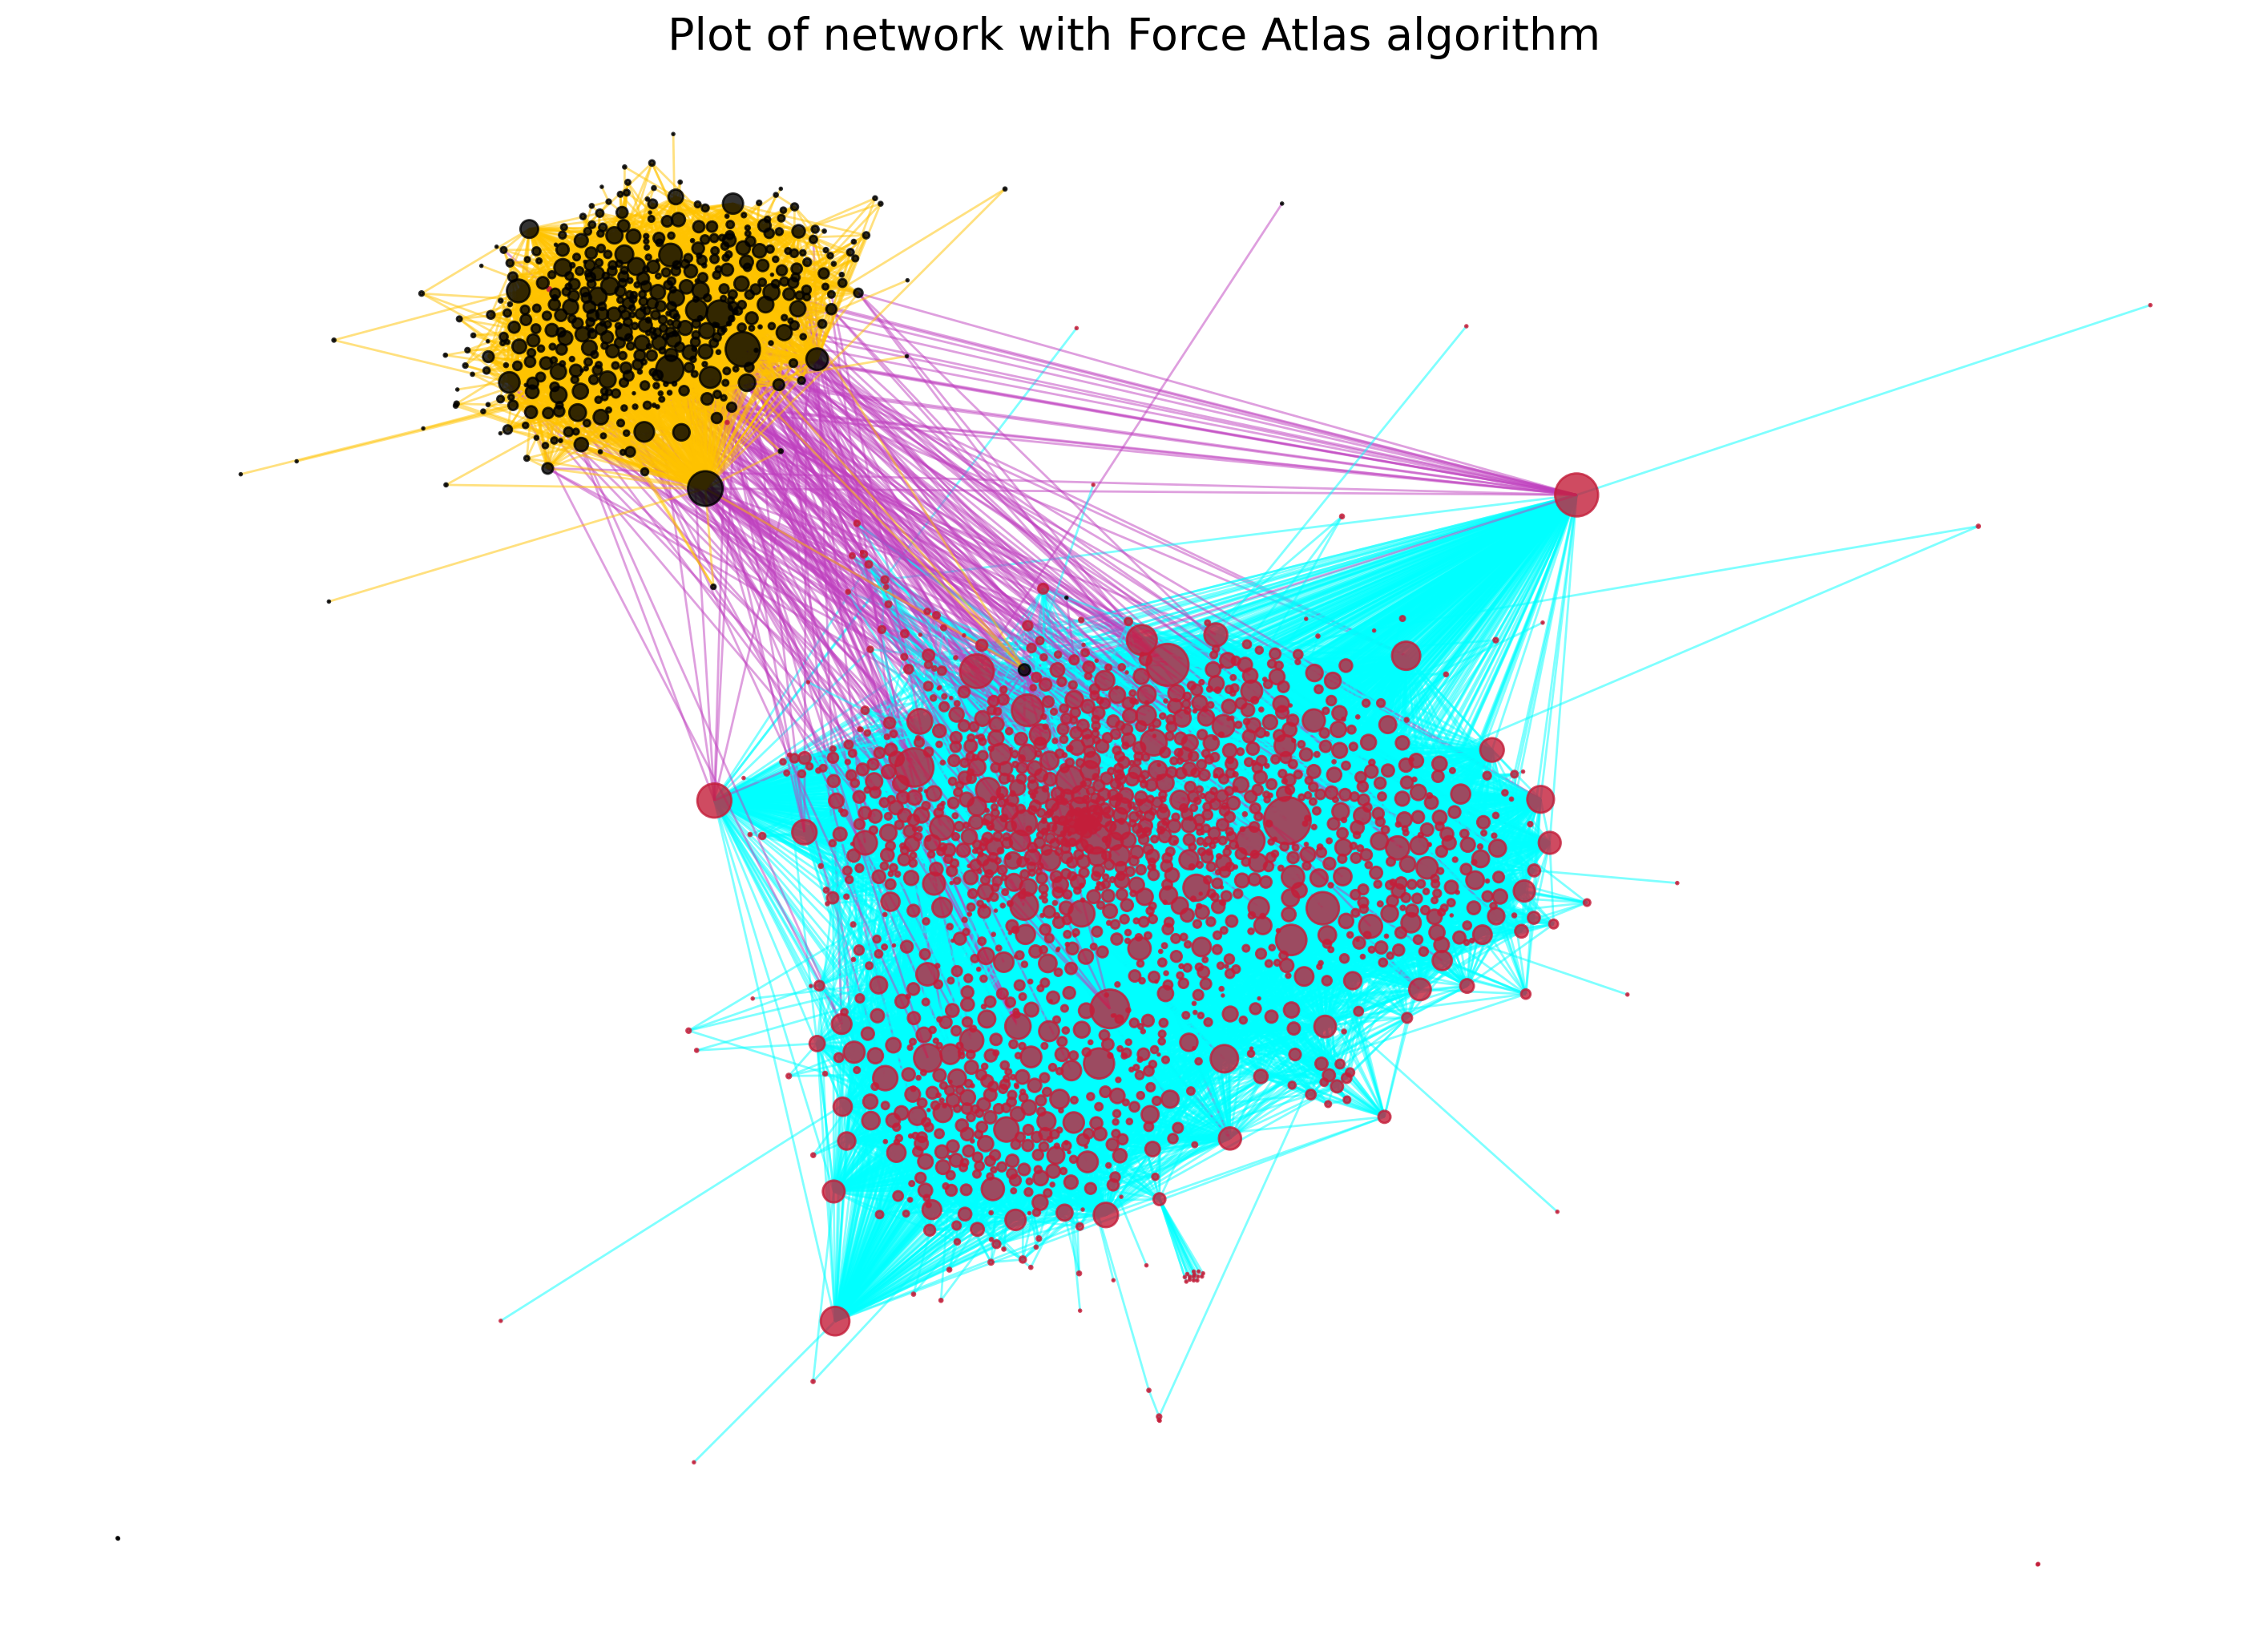

In [54]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        # Log
                        verbose=True)

fig = plt.figure(figsize=(18,13), dpi=200)
plt.title("Plot of network with Force Atlas algorithm", fontsize=20)
positions = forceatlas2.forceatlas2_networkx_layout(G_undirected, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_undirected, positions, node_size=node_size, node_color=color_map, alpha=0.8)
nx.draw_networkx_edges(G_undirected, positions, edge_color=edge_color, alpha=0.5)
plt.axis('off')
plt.show()

# Communities

Find and visualize the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.

Write a paragraph about your work to identify the communities. The paragraph should include

* Information about the algorithm you used to find communities.
* The value of modularity for your network.
* The number of communities and their sizes (in terms of number of nodes).

First we partition the dataset into two communities: One for all the Marvel characters and one for that DC characters.
The modularity is then calculated for this partition:

In [4]:
def computeModularity(G, partition):
    #Here the partition input is an attribute that we will partition the data set by
    partitions = np.unique(list(nx.get_node_attributes(G,partition).values()))
    partition_dic = {part: [] for part in partitions}
    
    N = len(G.nodes())
    L = len(G.edges())
    
    modularity = 0
    #sort nodes into their respective communities
    for key in partition_dic.keys():
        for node in G.nodes():
            part = G.nodes[node][partition]
            partition_dic[part].append(node)
        community = nx.Graph.subgraph(G, partition_dic[key])
        k_c = sum([G.degree(v) for v in community])
        L_c = len(community.edges())

        #compuute modularity
        modularity += (L_c / L) - (k_c/(2*L))**2
        
    return modularity
computeModularity(G_undirected,'universe')

0.2855944173634546

The universes are a decent partitioning, as the modularity is 0.286. We would expect characters to interact more with characters from the same universe, so it makes sense that creating communities from this attribute would yield good results.

We now create communities within the marvel universe using the Louvain algorithm:

In [5]:
import community
#find marvel nodes
marvel_nodes = (
    node
    for node, data
    in G_undirected.nodes(data=True)
    if data.get("universe") == "marvel"
)
# nx.get_node_attributes(G,'universe')
m_G = G_undirected.subgraph(marvel_nodes)
partition = community.best_partition(m_G)


In [77]:
with open('partition.pickle', 'wb') as handle:
    pickle.dump(partition, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
def computeModularity(G, partition):
    #Here we use the partition calculated by community as the partition input instead. The function has been modified accordingly
    partitions = np.unique(list(partition.values()))
    partition_dic = {part: [] for part in partitions}
    N = len(G.nodes())
    L = len(G.edges())
    
    modularity = 0
    for key in partition_dic:#_dic.keys():
        for node in G.nodes():
            part = partition[node]
            partition_dic[part].append(node)
        community = nx.Graph.subgraph(G, partition_dic[key])
        k_c = sum([G.degree(v) for v in community])
        L_c = len(community.edges())


        modularity += (L_c / L) - (k_c/(2*L))**2
        
    return modularity
modularity = computeModularity(m_G,partition)
modularity

0.39162813662173773

The modularity of this partition is higher than for the communities based on character's universe. This is to be expected as the Louvain algorithm optimises for modularity.

In [7]:
print("Number of partitionings:", len(np.unique(list(partition.values()))))


#Count number of nodes in each partitioning:
partitions = np.unique(list(partition.values()))
partition_dic = {part: [] for part in partitions}
for part in partition_dic.keys():
    count = 0
    for key in partition:
        if partition[key] == part:
            count += 1
    partition_dic[part]=count
print("Partitioning sizes:",partition_dic)

Number of partitionings: 16
Partitioning sizes: {0: 218, 1: 311, 2: 302, 3: 31, 4: 350, 5: 1, 6: 20, 7: 1, 8: 23, 9: 298, 10: 28, 11: 4, 12: 11, 13: 11, 14: 2, 15: 4}


Taking a closer look at the Louvain-partition there are 16 communities, with the largest consisting of 350 nodes, and the smallest containing only a single node.

In [46]:
#find top 10 largest communities
top_10  =[x[0] for x in sorted(partition_dic.items(), key=lambda x: x[1], reverse=True)][:10]
top_10

[4, 1, 2, 9, 0, 3, 10, 8, 6, 12]

The largest community is community 4, and the rest of the 10 largest communities are presented from left to right.

In [118]:
#plot communities
len([])

0

Initially we observed how well the universe parameter works as a partition. We can measure how good the communities that are based on this attribute by calculating the modularity. This partition got a modularity score of 0.286 which is good, which is as expected, since the plot of the network cleary shows the two universes as being more intraconnected than interconnected.

Within each universe there are also communities of related characters. In order to find the best partition for these communities we use the python louvain algorithm. The Louvain algorithm optimimses modularity, and thus, the resulting partition will have the highest possible modularity that can be reached from a given initialisation. 
The resulting partition had 16 communities of varying sizes. The largest community, community 4, contained 350 nodes, while the smallest, community 5 and 7, had only a single node. We chose to look at communities in the Marvel network. With the Louvain partition a modularity of 0.392 was reached. This should be the maximum modularity possible for a partition of the marvel nodes, and notably is it outperforms the "universe" partition's modularity score of 0.286, which was already a quite good partition.


> For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

In [8]:
import pandas as pd
#load dataframe:
df = pd.read_pickle("df.pickle")


In [9]:
from nltk.corpus import stopwords
from tqdm import tqdm
community_dic = {part: [] for part in partition_dic.keys()}
for part in tqdm(partition_dic.keys()):#for each community 
    community_doc = str()
    for node in [key for (key,value) in partition.items() if value==part]:#for each character in that community
        tokens = list(df.loc[df["WikiLink"]==node]['WikiText'])#Extract clean text from data frame
        
        
        if len(tokens)!=0:#handle nodes with no text
            community_doc +=' '+ tokens[0]#add extra space to ensure we can split into tokens later
        else:
            break
    #tokenize:
    community_dic[part]=community_doc

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.91it/s]


In [29]:
#calculate TF

from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
alphabet = 'abcdefghijklmnopqrstuvwxyz'

token_dic = {}
for part in tqdm(community_dic.keys()):#for each community
    tokens = word_tokenize(community_dic[part])#divide text into tokens
    text = community_dic[part]
    token_list = []
    for token in tokens:
        if token not in TF_dic.keys() and len(token)!=0:
            token = token.lower()
            
            if token[0] in alphabet and token[-1] in alphabet:#remove punctuation and signs
                token_list.append(token)
    token_dic[part]=token_list

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:41<00:00,  2.61s/it]


In [49]:
TF_outer_dic =  {} 
for part in tqdm(top_10):
    TF_dic = {}
    for token in token_dic[part]:
        if token not in TF_dic.keys():
            TF_dic[token]=token_dic[part].count(token)#count frequency
    TF_outer_dic[part]=TF_dic

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [31:50<00:00, 191.07s/it]


In [50]:
with open('TF_dict.pickle', 'wb') as handle:
    pickle.dump(TF_outer_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [91]:
N = 10
IDF_outer_dic = {}
for part in top_10:#for each community
    IDF_dic = {}
    for word in tqdm(TF_outer_dic[part].keys()):#for each word in that community
        
        count = 0
        for part2 in top_10:
            if word in token_dic[part2]:
                count += 1 #count occurences in all documents
        IDF_dic[word]=np.log(N/count)#uses natural log
    IDF_outer_dic[part]=IDF_dic

100%|██████████████████████████████████████████████████████████████████████████████| 2360/2360 [00:30<00:00, 76.68it/s]


In [92]:
TF_IDF_outer_dic = {}
for part in tqdm(top_10):
    TF_IDF_dic = {}
    for word in IDF_outer_dic[part].keys():
        TF_IDF_dic[word]=TF_outer_dic[part][word]*IDF_outer_dic[part][word]
    TF_IDF_outer_dic[part]=TF_IDF_dic
massive_dic = {'TF':TF_outer_dic,'IDF':IDF_outer_dic,'TF_IDF':TF_IDF_outer_dic}

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 58.48it/s]


In [103]:
TF_big_dic[4]

{'the': 58400,
 'fall': 140,
 'of': 27750,
 'mutants': 3423,
 'was': 8503,
 'a': 20740,
 'comic': 822,
 'book': 359,
 'crossover': 123,
 'event': 216,
 'by': 10072,
 'marvel': 6778,
 'comics': 5655,
 'spanning': 2,
 'january': 187,
 'to': 28654,
 'march': 264,
 'it': 3141,
 'spanned': 3,
 'three': 272,
 'issues': 170,
 'each': 315,
 'uncanny': 1844,
 'x-men': 10787,
 'x-factor': 783,
 'and': 28681,
 'new': 3593,
 'unlike': 63,
 'most': 741,
 'crossovers': 6,
 'however': 1070,
 'various': 283,
 'titles': 73,
 'storylines': 17,
 'did': 464,
 'not': 2000,
 'intertwine': 1,
 'but': 3096,
 'were': 1823,
 'instead': 306,
 'linked': 26,
 'thematically': 2,
 'as': 8992,
 'team': 2155,
 'underwent': 31,
 'major': 138,
 'ordeals': 2,
 'drastic': 7,
 'changes': 74,
 'in': 19199,
 'their': 3206,
 'status': 131,
 'quo': 22,
 'computer': 79,
 'game': 275,
 'ii': 194,
 'based': 170,
 'on': 4497,
 'this': 2837,
 'storyline': 519,
 'promotion': 4,
 'faux-advertisement': 1,
 'for': 5161,
 'mutant': 3125

In [93]:
with open('IDF_dict.pickle', 'wb') as handle:
    pickle.dump(IDF_outer_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [104]:
with open('TF_IDF_dict.pickle', 'wb') as handle:
    pickle.dump(TF_IDF_outer_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('TF_IDF_dict_deluxe.pickle', 'wb') as handle:
    pickle.dump(massive_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [102]:
for part in top_10:
    print('Highest TF-IDF scores from community ' + str(part)+':\n',[x for x in sorted(TF_IDF_outer_dic[part].items(), key=lambda x: x[1], reverse=True)][:10],'\n')

Highest TF-IDF scores from community 4:
 [('mystique', 684.829414393226), ('uncanny', 657.7085966230226), ('betsy', 628.4738038581387), ('rogue', 561.9081861425898), ('emma', 494.990029429245), ('sinister', 476.6003069736693), ('frost', 462.2971895082216), ('cyclops', 446.557029811293), ('mojo', 415.23498140799785), ('phoenix', 406.1063708939626)] 

Highest TF-IDF scores from community 1:
 [('aries', 74.03414397196862), ('anaconda', 69.63809562243578), ('creel', 62.60658582494868), ('batroc', 58.224363167035406), ('thunderstrike', 54.9774439124493), ('masterson', 47.64711805745607), ('zemo', 47.08109259991267), ('asp', 37.56792000684036), ('mamba', 36.04365338911715), ('strongbow', 34.53877639491069)] 

Highest TF-IDF scores from community 2:
 [('spider-man', 309.0223924244047), ('cat', 294.58755173797675), ('octavius', 205.24912393981074), ('carnage', 192.6949161956648), ('daredevil', 191.53444489509928), ('octopus', 176.2348401992668), ('felicia', 170.60041871801462), ('flash', 161.5

Term Frequency(TF) is simply a count of how often a word occurs in a given document. It can be measured in a variety of ways, with the most straight-forward version being simply a count of occurences. More complex ways of calculating TF exist, such as dividing the count by the number of terms in the document(https://en.wikipedia.org/wiki/Tf%E2%80%93idf). TF can give a good idea of what words are prevalent in a text, however, if you only look at the most frequent words, the words with the highest TF-scores will be uninteresting words like "the", "and", etc. One way to handle this problem is to simpy remove stop-words from the document, however, the most common words excluding stop-words are still not necessarily the words that tells us the most about the given document. 

We can ensure that we get the most defining terms from a document by multiplying TF by the Inverse document frequency(IDF). IDF counts how many documents a given term is in, and outputs the logarithmically scaled inverse frequency. This means the highest IDF-scores are given to terms that appear in only a single document.

When TF and IDF scores are multiplied together, the resulting score shows if terms occur frequently in the given document, and not in other documents. A high TF-IDF score indicates that the given term is used frequently in the given document, and not in others.

> Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

In [76]:
from wordcloud import WordCloud

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)
wc = WordCloud(background_color="white", repeat=True, mask=mask)

for part in top_10:
    wordcloud = wc.generate_from_frequencies(TF_IDF_outer_dic[part])
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

ImportError: The _imagingft C module is not installed

# Sentiment

First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment. Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.

Now grab the good/bad character names ([from this file](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2022/b1668fe5fbea0765ed6f9cf896bfaf208a13765b/files/wiki_meta_data.csv), see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.

Finally use the label permutation test (see Week 5) to investigate the two hypotheses below
* H1: Good characters have a higher average value for sentiment than a similarly sized set of randomly selected characters.
* H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

Write a short paragraph reflecting on your findings.